### Оценка неопределенностей в задачах машинного обучения

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import date
import datetime

from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
class linear_regression:
    def __init__(self):
        self.theta = None
        pass
    
    def fit(self, X, y):
        assert X.ndim == 2, "X should be 3-dimensional: (N of objects, n of features)"
        assert ((y.ndim == 2)&(y.shape[1] == 1)), "y should be 2-dimensional: (N of objects, one column)"
        
        # attaching ones as first column-vector - x[:,0]
        X_0 = np.ones((X.shape[0], 1), dtype=np.float64)
        X_matrix = np.concatenate([X_0, X], axis=1)
        
        # making y_train of shape (N,1)
        y_column = np.squeeze(np.asarray(y)).reshape((-1,1))
        
        m1 = np.dot(X_matrix.T, X_matrix)
        m2 = np.linalg.inv(m1)
        m3 = np.dot(m2, X_matrix.T)
        theta_star = np.dot(m3, y_column)
        self.theta = theta_star
    
    def predict(self, X):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert self.theta is not None, "theta is None. perhaps, fit the model first."
        
        X_0 = np.ones((X.shape[0], 1))
        X_matrix = np.concatenate([X_0, X], axis=1)
        y_pred = np.dot(X_matrix, self.theta)
        return y_pred

In [3]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.sum(np.square(np.squeeze(np.asarray(y_true)) - np.squeeze(np.asarray(y_pred))))/y_pred.shape[0])

In [78]:
def AddPoint(plot, x, y, color, size):
    plot.scatter(x, y, c=color, s=size)
    return

In [4]:
# загрузка датасета
X_train = np.load('X_train.npy')
X_inference = np.load('X_inference.npy')
y_train = np.load('y_train.npy')
print(np.shape(X_train), np.shape(X_inference), np.shape(y_train))

(10000, 4) (100, 4) (10000, 1)


#### 1. Постановка задачи
Задача состоит в аппроксимации целевой переменной методом восстановления линейной регрессии.
Тип задачи - обучение с учителем, линейная регрессия.
Для обучения модели используется датасет из 10000 объектов. Признаковое описание объектов заключается в 4 численных признаках для каждого объекта (т.е. размерность признакового пространства 4, тип признаков - действительные числа).
Целевая переманная - действительное число размерностью 1.
Для обучения модели используется аналитическая оптимизация (минимализация) функции потерь. В качестве функции потерь выбрано среднеквадратичное отклонение (MSE) прогнозируемых значений от фактических значений в датасете.
Мера качества модели - корень среднеквадратичного отклонения (RMSE) (чем меньше RMSE, тем качественнее модель).

#### 2. Исследование исходных данных на скоррелированность признаков

In [6]:
np.corrcoef(X_train.T)

array([[1.        , 0.99930832, 0.00924955, 0.88100664],
       [0.99930832, 1.        , 0.0096915 , 0.88030952],
       [0.00924955, 0.0096915 , 1.        , 0.01899396],
       [0.88100664, 0.88030952, 0.01899396, 1.        ]])

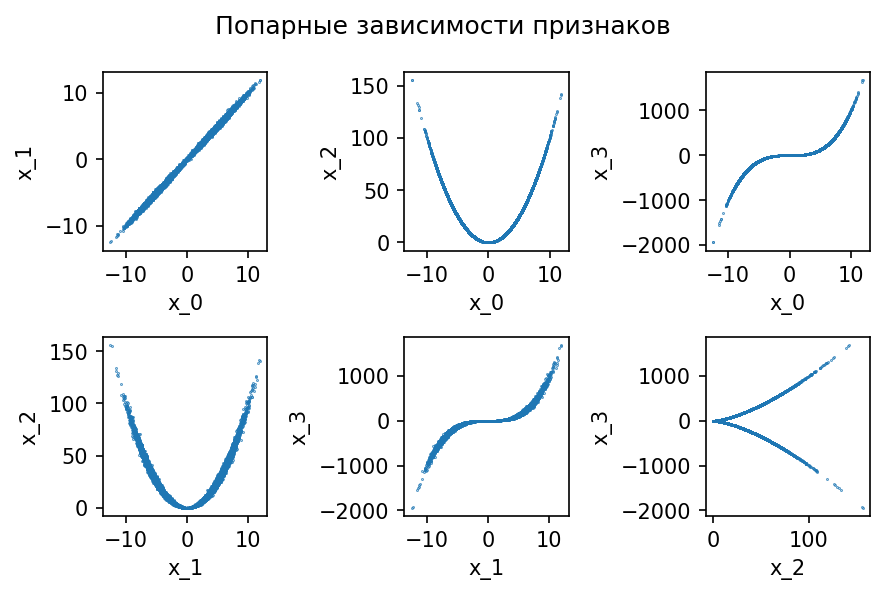

In [7]:
f = plt.figure(figsize=(6,4), dpi=150)
pic=1
for p in range(0,4):
    for k in range(0,4):
        if(k!=p and k>p):
            plt.subplot(2,3,pic)
            plt.scatter(X_train[:,p], X_train[:,k],s=0.1)
            plt.xlabel('x_'+str(p))
            plt.ylabel('x_'+str(k))
            pic+=1
plt.suptitle("Попарные зависимости признаков")
plt.tight_layout()

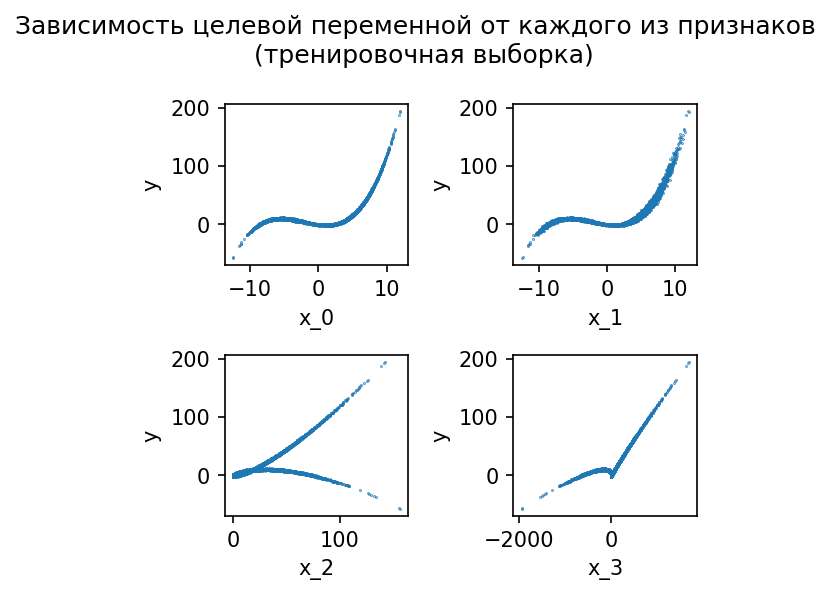

In [8]:
f = plt.figure(figsize=(4,4), dpi=150)
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(X_train[:,i], y_train[:],s=0.1)
    plt.xlabel('x_'+str(i))
    plt.ylabel('y')
plt.suptitle("Зависимость целевой переменной от каждого из признаков \n (тренировочная выборка)")
plt.tight_layout()

Видно, что признаки 0 и 1 сильно скореллированы, и нет смысла рассматривать их вместе. Поэтому составим из 0 и 1 признака линейную комбинацию и сделаем её новым признаком. Теперь размерномть признакового пространства - 3:

In [6]:
X = X_train[:, 1:]
X_in= X_inference[:, 1:]
for i in range(0, 10000):
    X[i, 0] = 0.5*(X_train[i, 0]+X_train[i, 1])
for i in range(0, 100):
    X_in[i, 0] = 0.5*(X_inference[i, 0]+X_inference[i, 1])
    
y = y_train

print(np.shape(X), np.shape(X_in), np.shape(y))

(10000, 3) (100, 3) (10000, 1)


In [7]:
fig = go.Figure(data=[go.Scatter3d(x=X[:,0],
                                   y=X[:,1],
                                   z=X[:,2],
                                   mode='markers',
                                   marker=dict(size=1))
                     ])
fig.update_layout(autosize=False,
                  width=500,
                  height=500,
                  margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
                  scene = dict(xaxis_title='x0',
                               yaxis_title='x1',
                               zaxis_title='x2'),
                 title_text="Визуализация признаков", title_x=0.5)
fig.show()

In [8]:
fig = go.Figure(data=[go.Scatter3d(
    x=X[:,0], y=X[:,1], z=X[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=y[:,0], 
        colorscale='Rainbow',
        opacity=1,
        colorbar=dict(thickness=20)
    )
)])

# tight layout
fig.update_layout(autosize=False,
                  width=600,
                  height=600,
                  margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
                  scene = dict(xaxis_title='x0',
                               yaxis_title='x1',
                               zaxis_title='x2'),
                 title_text='Визуализация целевой переменной на новых признаках', title_x=0.5)
fig.show()

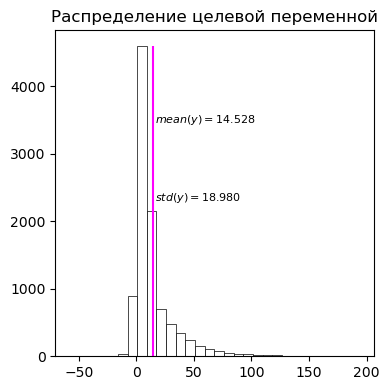

In [11]:
f = plt.figure(figsize=(4,4), dpi=100)
h_counts,h_bins,_ = plt.hist(y[:], bins=30, color='white', ec="black", linewidth=0.5)
_ = plt.title("Распределение целевой переменной")
mean_y = np.mean(y[:])
std_y = np.std(y[:])
_ = plt.vlines(mean_y, 0, h_counts.max(), color='magenta')
_ = plt.text(mean_y+std_y/10, 3*h_counts.max()/4, '$mean(y) = %.3f$' % mean_y, fontsize=8, weight='bold')
_ = plt.text(mean_y+std_y/10, 2*h_counts.max()/4, '$std(y) = %.3f$' % (std_y), fontsize=8, weight='bold')
_ = plt.tight_layout()

In [12]:
print(np.min(y), np.max(y))

-57.872737129178915 193.52009607281937


#### 3. Оценка параметров модели

Обучим модель на всей тренировочной выборке:

In [13]:
lr = linear_regression()
lr.fit(X,y)
theta_init = lr.theta
print("Оценочные значения параметров модели: ")
for i in range(0,4):
    print('θ_%d = %.5f' % (i, theta_init[i]))

Оценочные значения параметров модели: 
θ_0 = -0.98637
θ_1 = -1.43906
θ_2 = 0.53442
θ_3 = 0.08096


#### 4. Исследование оптимального размера bootstrap-выборки

Пусть число bootstrap-выборок $N_b = 100$. Будем менять число элементов в каждой выборке ($B$), и посмотрим как от этого числа меняются параметры модели и их разброс от выборки к выборке

In [14]:
def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0,X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices, :], X[oob_indices, :], y[oob_indices, :]
    else:
        return X[sample_indices, :], y[sample_indices, :]
    
def stat_bootstrap(Nb, B, X, y):
    theta_values_curr_sample_size = []
    for i in tqdm(range(B), total=B):
        Xtrain,ytrain = sample_bootstrap(X,y, sample_size=Nb)
        lr = linear_regression()
        lr.fit(Xtrain,ytrain)
        theta_values_curr_sample_size.append(np.copy(lr.theta))

    theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)

    f = plt.figure(figsize=(6,6), dpi=100)
    for i in range(0,4):
        _ = plt.subplot(2,2, i+1)
        h_counts,h_bins,_ = plt.hist(theta_values_curr_sample_size[:,i], bins=30, color='white', ec="black", linewidth=0.5)
        _ = plt.title("$\\theta_%d$" % i)
        mean_theta_i = np.mean(theta_values_curr_sample_size[:,i])
        std_theta_i = np.std(theta_values_curr_sample_size[:,i])
        _ = plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
        _ = plt.text(mean_theta_i+std_theta_i/10, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize=8, weight='bold')
        _ = plt.text(mean_theta_i+std_theta_i/10, 2*h_counts.max()/4, '$std(\\theta_%d) = %.3f$' % (i, std_theta_i), fontsize=8, weight='bold')

    _ = plt.tight_layout()
    return


100%|██████████| 10000/10000 [00:01<00:00, 8156.73it/s]


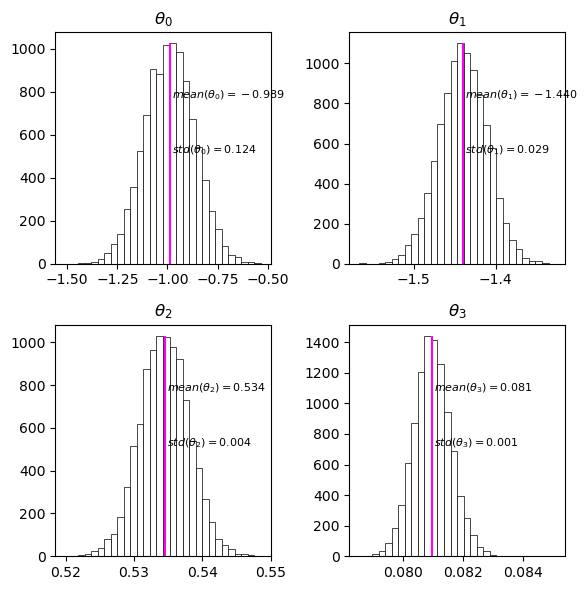

In [15]:
Nb = 100
B = 10000 # изменяю в диапазоне от 100 до 10000
stat_bootstrap(Nb, B, X, y)

100%|██████████| 10000/10000 [00:19<00:00, 513.77it/s]


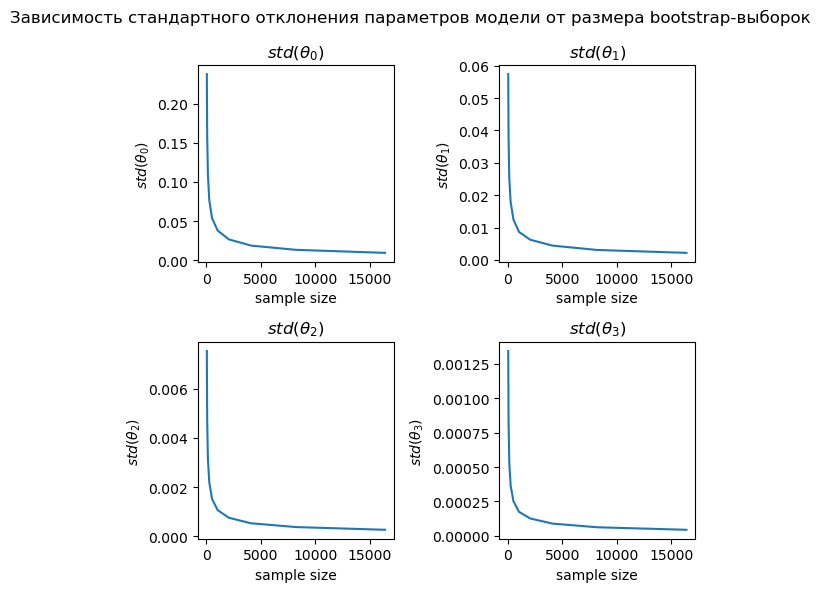

In [16]:
theta_values_per_sample_size = []
for sample_size in [2**i for i in range(5, 15)]:
    theta_values_curr_sample_size = []
    for i in tqdm(range(B), total=B):
        Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
        lr = linear_regression()
        lr.fit(Xtrain,ytrain)
        theta_values_curr_sample_size.append(np.copy(lr.theta))
    theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
    theta_values_per_sample_size.append({'sample_size': sample_size, 'theta_values': theta_values_curr_sample_size})
    
f = plt.figure(figsize=(6,6), dpi=100)
for i in range(4):
    _ = plt.subplot(2,2,i+1)
    _ = plt.plot([t['sample_size'] for t in theta_values_per_sample_size],
                 [np.std(t['theta_values'][:,i]) for t in theta_values_per_sample_size],
                 label='$std(\\theta_%d)$' % i)
    _ = plt.ylabel('$std(\\theta_%d)$' % i)
    _ = plt.xlabel('sample size')
    _ = plt.title('$std(\\theta_%d)$' % i)
plt.suptitle("Зависимость стандартного отклонения параметров модели от размера bootstrap-выборок")
plt.tight_layout()

Видно, что минимальный разброс значений параметров модели на bootstrap-выборках достигается при увеличении размера выборок. Поэтому зафиксируем максимально возможный размер выборок: $N_b = 10000$ (совпадает с размером тренировочной выборки)

#### 5. Исследование оптимального количества bootstrap-выборок

Зафиксировав размер bootstrap-выборок, найдем оптимальное число выборок

In [17]:
theta_values_per_B = []
sample_size=10000
for B in [10*i for i in range(1, 180)]:
    theta_values_curr_B = []
    for i in tqdm(range(B), total=B):
        Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
        lr = linear_regression()
        lr.fit(Xtrain,ytrain)
        theta_values_curr_B.append(np.copy(lr.theta))
    theta_values_curr_B = np.concatenate([t.T for t in theta_values_curr_B], axis=0)
    theta_values_per_B.append({'sample_number': B, 'theta_values': theta_values_curr_B})

100%|██████████| 1790/1790 [00:02<00:00, 769.71it/s]


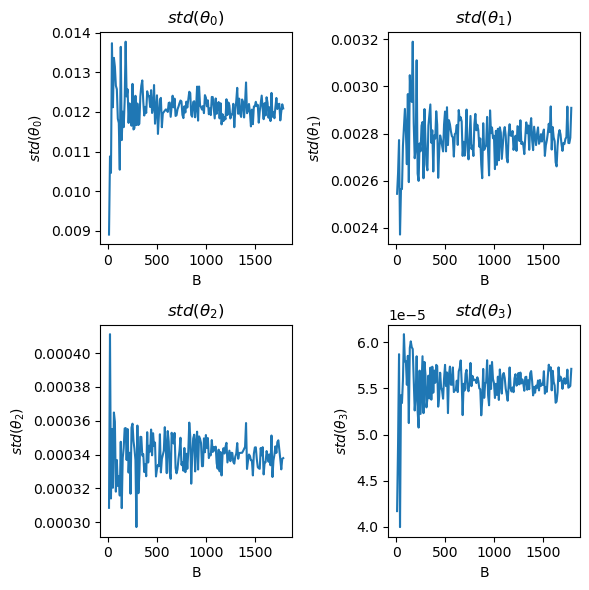

In [18]:
f = plt.figure(figsize=(6,6), dpi=100)
for i in range(0, 4):
    _ = plt.subplot(2,2,i+1)
    _ = plt.plot([t['sample_number'] for t in theta_values_per_B],
                 [np.std(t['theta_values'][:,i]) for t in theta_values_per_B],
                 label='$std(\\theta_%d)$' % i)
    _ = plt.ylabel('$std(\\theta_%d)$' % i)
    _ = plt.xlabel('B')
    _ = plt.title('$std(\\theta_%d)$' % i)
plt.tight_layout()

Начиная примерно с $B=700$, стандартные отклонения параметров незначительно колеблются относительно средних начений.
Поэтому зафиксируем число bootstrap-выборок $B = 1000$

#### 6. Оценка средних значений и неопределенностей для параметров модели с использованием оптимальных количества и размера bootstrap-выборок

Используя зафиксированное ранее число вборок заданного размера, оптимизируем модель на каждой из bootstrap-выборок как на тренировочной. Значения параметров модели оцениваем как среднее всех полученных параметров; неопределенность параметров модели оцениваем как стандартное отклонение всех полученных параметров.

In [19]:
B=1000
Nb=10000
theta_values = []

for i in tqdm(range(B), total=B):
    Xtrain,ytrain = sample_bootstrap(X,y, sample_size=Nb)
    lr = linear_regression()
    lr.fit(Xtrain,ytrain)
    theta_values.append(np.copy(lr.theta))
    
theta_values = np.concatenate([t.T for t in theta_values], axis=0)
theta_values.shape

100%|██████████| 1000/1000 [00:01<00:00, 672.96it/s]


(1000, 4)

In [79]:
mean_theta = []
for i in range(0,4):
    mean_theta_i = np.mean(theta_values[:,i])
    std_theta_i = np.std(theta_values[:,i])
    mean_theta.append(mean_theta_i)
    print('θ_%d = %.3f,' % (i, mean_theta_i), 'std θ_%d = %.5f' % (i, std_theta_i))

θ_0 = -0.987, std θ_0 = 0.01193
θ_1 = -1.439, std θ_1 = 0.00283
θ_2 = 0.534, std θ_2 = 0.00033
θ_3 = 0.081, std θ_3 = 0.00006


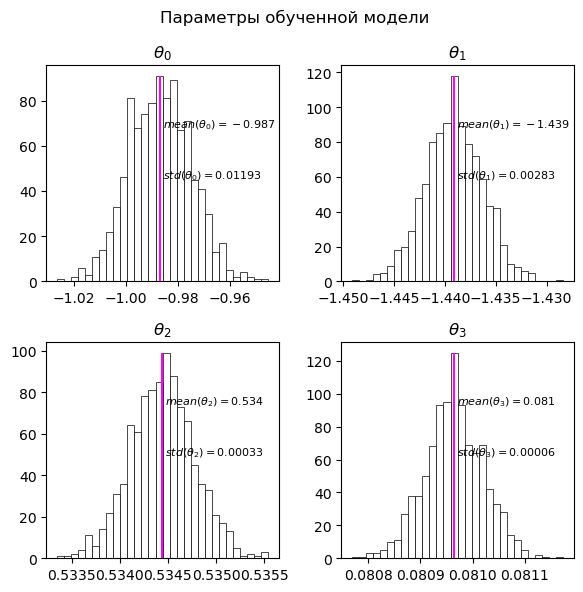

In [22]:
f = plt.figure(figsize=(6,6), dpi=100)
for i in range(0,4):
    _ = plt.subplot(2,2, i+1)
    h_counts,h_bins,_ = plt.hist(theta_values[:,i], bins=30, color='white', ec="black", linewidth=0.5)
    _ = plt.title("$\\theta_%d$" % i)
    mean_theta_i = np.mean(theta_values[:,i])
    std_theta_i = np.std(theta_values[:,i])
    _ = plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
    _ = plt.text(mean_theta_i+std_theta_i/10, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 2*h_counts.max()/4, '$std(\\theta_%d) = %.5f$' % (i, std_theta_i), fontsize=8, weight='bold')
plt.suptitle("Параметры обученной модели")
_ = plt.tight_layout()

#### 7. Оценка среднего значения качества модели

Для каждой bootstrap-выбороки, обучаем модель на этой выборке как на тренировочной, а заем оцениваем качество модели на OOB-выборке как на тестовой

In [23]:
B=1000
Nb=10000
quality_values = []

for i in tqdm(range(B), total=B):
    Xtrain,ytrain,Xoob,yoob = sample_bootstrap(X,y, sample_size=Nb, return_OOB_sample = True)
    lr = linear_regression()
    lr.fit(Xtrain,ytrain)
    y_pred = lr.predict(Xoob)
    RMSE_val = RMSE(yoob, y_pred)
    quality_values.append(np.copy(RMSE_val))

np.shape(quality_values)

100%|██████████| 1000/1000 [02:03<00:00,  8.07it/s]


(1000,)

In [24]:
mean_q = np.mean(quality_values[:])
std_q = np.std(quality_values[:])
print("Качество модели на тестовых выборках: ")
print("RMSE = %.5f" %mean_q)

Качество модели на тестовых выборках: 
RMSE = 0.71211


In [25]:
# оценим качество на тренировочной выборке:
y_pred_train = lr.predict(X)
RMSE_val_train = RMSE(y, y_pred_train)
print("Качество модели на тренировочной выборке: ")
print("RMSE = %.5f" % RMSE_val_train)

Качество модели на тренировочной выборке: 
RMSE = 0.71199


#### 8. Оценка неопределенности качества модели

оценка доверительного интервала для качества модели с уровнем доверия 0.95;

In [26]:
q_025=np.quantile(quality_values, 0.025)
q_975=np.quantile(quality_values, 0.975)
print(q_025, q_975)

0.6994758527324476 0.7248818003344024


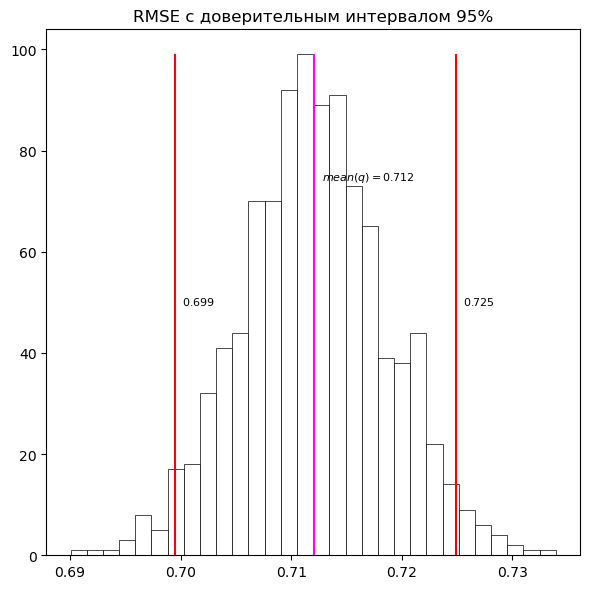

In [27]:
f = plt.figure(figsize=(6,6), dpi=100)
h_counts,h_bins,_ = plt.hist(quality_values[:], bins=30, color='white', ec="black", linewidth=0.5)
_ = plt.title("RMSE с доверительным интервалом 95%")
mean_q = np.mean(quality_values[:])
std_q = np.std(quality_values[:])
_ = plt.vlines(mean_q, 0, h_counts.max(), color='magenta')
_ = plt.vlines(q_025, 0, h_counts.max(), color='red')
_ = plt.vlines(q_975, 0, h_counts.max(), color='red')
_ = plt.text(mean_q+std_q/10, 3*h_counts.max()/4, '$mean(q) = %.3f$' % mean_q, fontsize=8, weight='bold')
_ = plt.text(q_025+std_q/10, 2*h_counts.max()/4, '$%.3f$' % q_025, fontsize=8, weight='bold')
_ = plt.text(q_975+std_q/10, 2*h_counts.max()/4, '$%.3f$' % q_975, fontsize=8, weight='bold')
_ = plt.tight_layout()

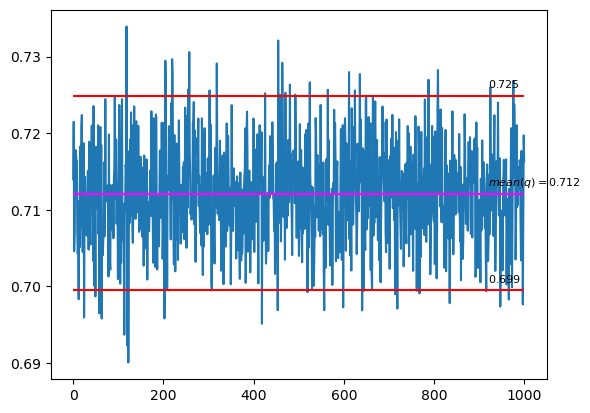

In [28]:
plt.plot(np.linspace(0, B, B, endpoint=True), quality_values)
_ = plt.hlines(mean_q, 0, 1000, color='magenta')
_ = plt.hlines(q_025, 0, 1000, color='red')
_ = plt.hlines(q_975, 0, 1000, color='red')
_ = plt.text(920, mean_q+0.001, '$mean(q) = %.3f$' % mean_q, fontsize=8, weight='bold')
_ = plt.text(920, q_025+0.001, '$%.3f$' % q_025, fontsize=8, weight='bold')
_ = plt.text(920, q_975+0.001, '$%.3f$' % q_975, fontsize=8, weight='bold')
plt.show()

#### 9. Аппроксмация целевой переменной на выборке вновь поступающих объектов

In [82]:
X_0 = np.ones((X_in.shape[0], 1))
X_matrix = np.concatenate([X_0, X_in], axis=1)
y_pred = np.dot(X_matrix, mean_theta)

In [83]:
np.shape(X_matrix)

(100, 4)

In [84]:
print(np.min(y_pred), np.max(y_pred))

-46.82130229203176 198.16113710022302


In [85]:
fig = go.Figure(data=[go.Scatter3d(
    x=X_in[:,0], y=X_in[:,1], z=X_in[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=y_pred[:], 
        colorscale='Rainbow',
        opacity=1,
        colorbar=dict(thickness=20)
    )
)])

fig.update_layout(autosize=False,
                  width=600,
                  height=600,
                  margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
                  scene = dict(xaxis_title='x1',
                               yaxis_title='x2',
                               zaxis_title='x3'),
                 title_text='Визуализация аппроксимации целевой переменной', title_x=0.5)
fig.show()

In [86]:
mean_y = np.mean(y_pred[:])
std_y = np.std(y_pred[:])

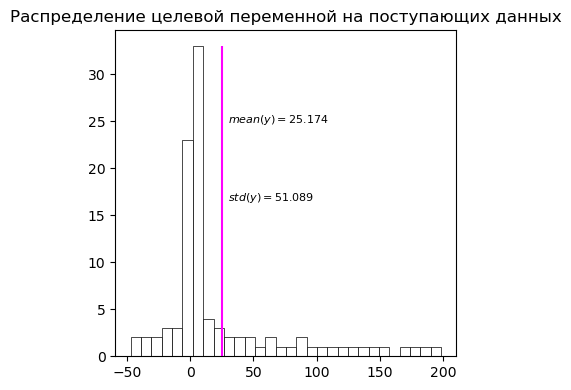

In [87]:
f = plt.figure(figsize=(4,4), dpi=100)
h_counts,h_bins,_ = plt.hist(y_pred[:], bins=30, color='white', ec="black", linewidth=0.5)
_ = plt.title("Распределение целевой переменной на поступающих данных")
_ = plt.vlines(mean_y, 0, h_counts.max(), color='magenta')
_ = plt.text(mean_y+std_y/10, 3*h_counts.max()/4, '$mean(y) = %.3f$' % mean_y, fontsize=8, weight='bold')
_ = plt.text(mean_y+std_y/10, 2*h_counts.max()/4, '$std(y) = %.3f$' % (std_y), fontsize=8, weight='bold')
_ = plt.tight_layout()

### Вводы

1. Неопределенность параметров модели мала по сравнению с их величиной (см. гистограммы в п.6), значит, модель хорошо подходит для описания предложенных данных.
2. Данных для обучения модели достаточно: в качестве размера bootstrap-выборок был использован весь размер тренировочной выборки; снижение неопределенности параметров модели при дальнейшем увеличении размера выборок было бы незначительным.
3. Средняя мера качества модели по out-of-bag выборкам при применении метода bootstrap составляет 0.7121 с доверительным интервалом 95% (0.699, 0.725). Мера качества модели на тренировочной выборке 0.7119. Итого, ошибка на тестовых выборках не на много выше ошибки на тренировочных данных. Значит, можно сделать вывод, что модель не переобучается. Малость меры качества модели по сравнению с разбросом целевой переменной означает также, что модель не недообучается.
